In [1]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [2]:
def average_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).mean(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def sum_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).sum(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def import_throughput(res_dir):
    throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    
#     throughput_csv['client'] *= 10
    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
#     throughput_csv['rxpck/s'] *= 1e-6
#     throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1']    

    net_wg = average_data(throughput_wg)
    net_phy = average_data(throughput_phy)
    
    return net_wg, net_phy

def import_cpu(res_dir):
    cpu_csv = pd.read_csv(f"{res_dir}/summary/server/cpu-sar.csv")
    
#     cpu_csv['client'] *= 10
    cpu_csv['used'] = 100 - cpu_csv['idle']

    cpu = average_data(cpu_csv, keep=['cpu', 'client', 'core'])
    
    per_core = cpu[cpu.core != -1]
    global_cpu = cpu[cpu.core == -1]
    
    return global_cpu, per_core

def import_iperf(res_dir):
    df_t = []
    for i in range(1, 2):
        try:
            net_client_csv = pd.read_csv(
                f"{res_dir}/summary/clients/throughput-{i}.csv",
            )
            net_df = average_data(net_client_csv, keep=['cpu', 'client', 'node'])
            net_df_sum = net_df.groupby(['cpu', 'client']).sum().reset_index()
            net_df_avg = net_df.groupby(['cpu', 'client']).median().reset_index()
            net_df_sum['throughput'] *= 1e-3
            net_df_sum['node'] = i
            df_t.append(net_df_sum)
        except:
            continue
    df = pd.concat(df_t, axis=0)
    
    df = df.groupby(['cpu', 'client']).sum().reset_index()
    
    return df

def import_latency(res_dir):
    df_t = []
    for i in range(1, 11):
        try:
            latency_csv = pd.read_csv(
                f"{res_dir}/summary/clients/latency-{i}.csv",
                names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
                skiprows=1
            )
        except:
            continue
        latency_df = average_data(latency_csv, keep=['cpu', 'client'])
#         latency_df['client'] *= 10
        latency_df[['mean', 'median', '90th', '99th', 'max', 'std']] *= 1e-3
        latency_df['node'] = i
        df_t.append(latency_df)
    df = pd.concat(df_t, axis=0)
    
    latency_df = df.groupby(['cpu', 'client']).median().reset_index()
    
    return latency_df

In [3]:
def infos_resdir(resdir):
    t = f"{maindir}/{resdir}"
    curr_dir_f = f"{t}/EXPERIMENT_DATA/CURRENT_EXP"
    with open(curr_dir_f) as f:
        curr_dir = f.readlines()[0].strip()
    return {
        'test': curr_dir,
        'path': t
    }


In [22]:
maindir = "../gonogo-2"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]

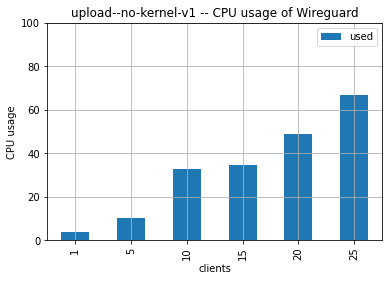

   cpu  client  core  run       usr     kernel    softirq       idle  \
0   18       1    -1  2.0  0.015667   1.340667   2.309667  96.333667   
1   18       5    -1  2.0  0.013500   3.556000   6.541167  89.890833   
2   18      10    -1  2.0  0.013333  15.295000  16.613333  67.523167   
3   18      15    -1  2.0  0.020000  13.519333  21.003833  65.458833   
4   18      20    -1  2.0  0.010000  22.122000  26.898333  51.395500   
5   18      25    -1  2.0  0.019000  32.246500  33.946667  33.328000   

        used  clients  run  decrypt_worker  decrypt_packet  spin_lock  \
0   3.666333        1  2.0       13.903333        0.054506   0.211059   
1  10.109167        5  2.0       17.116667        0.178595   0.739654   
2  32.476833       10  2.0       24.873333        0.595409   4.686407   
3  34.541167       15  2.0       33.890000        0.731121   7.190320   
4  48.604500       20  2.0       41.623333        1.164888  12.701976   
5  66.672000       25  2.0       49.600000        1.78458

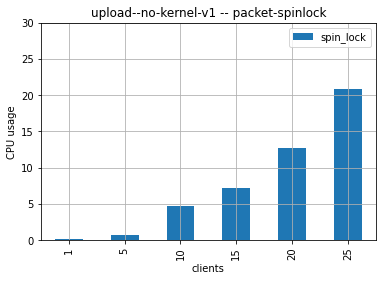

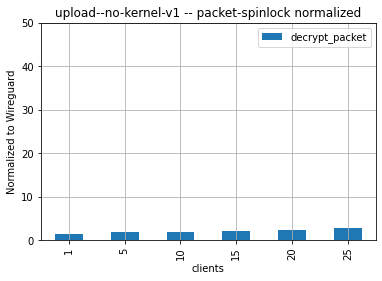

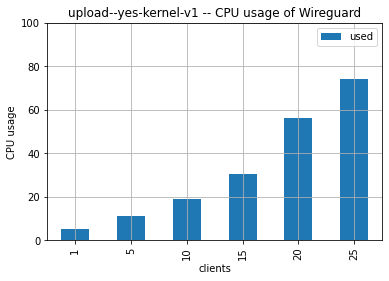

   cpu  client  core  run       usr     kernel    softirq       idle  \
0   18       1    -1  2.0  0.016167   2.969333   2.178667  94.797500   
1   18       5    -1  2.0  0.016833   5.534167   5.613833  88.835500   
2   18      10    -1  2.0  0.016833   8.740333  10.199500  81.221500   
3   18      15    -1  2.0  0.019667  14.563333  15.751667  69.665167   
4   18      20    -1  2.0  0.015000  28.013167  28.149667  43.790000   
5   18      25    -1  2.0  0.012833  32.959667  38.830500  26.076667   

        used  clients  run  decrypt_worker  decrypt_packet  spin_lock  \
0   5.202500        1  2.0       26.850000        1.014314   0.106478   
1  11.164500        5  2.0       29.486667        1.792274   0.685872   
2  18.778500       10  2.0       30.210000        2.956362   1.224984   
3  30.334833       15  2.0       40.596667        5.486560   3.612879   
4  56.210000       20  2.0       43.860000       10.925350   7.241722   
5  73.923333       25  2.0       44.886667       15.18878

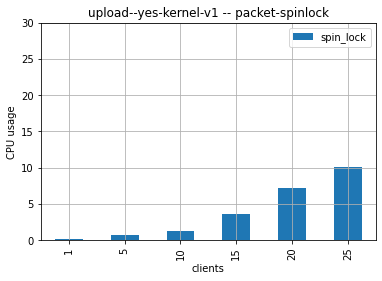

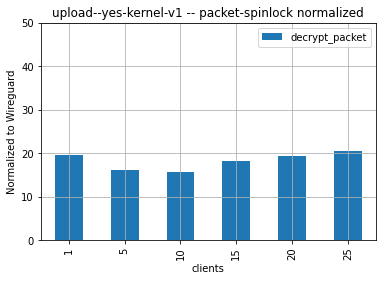

In [24]:
for res_dir in res_dirs:
    df = pd.read_csv(f"{res_dir['path']}/summary/decrypt_time.csv").groupby('clients').mean().reset_index()

    df = pd.read_csv(f"{res_dir['path']}/summary/decrypt_time.csv").groupby('clients').mean().reset_index()
    df = df.reset_index(drop=True)

    cpu, pcpu = import_cpu(res_dir['path'])
    cpu = cpu.reset_index(drop=True)

    df_2 = pd.concat([cpu, df], axis=1)
    df_2.decrypt_packet = df_2.decrypt_packet * df_2.used / 100
    df_2.spin_lock = df_2.spin_lock * df_2.used / 100
    
    df_2.plot.bar(x='clients', y='used', grid=True, ylabel="CPU usage",
                 ylim=[0, 100], 
                 title=f"{res_dir['test']} -- CPU usage of Wireguard")
    plt.show()
    df_2.plot.bar(x='clients', y=['spin_lock'], 
                grid=True, ylabel="CPU usage", 
                ylim=[0, 30], stacked=True,
                 title=f"{res_dir['test']} -- packet-spinlock")
    print(df_2)
    plt.show()
    df.plot.bar(x='clients', y=['decrypt_packet'], 
                grid=True, ylabel="Normalized to Wireguard", 
                ylim=[0, 50], stacked=True,
                title=f"{res_dir['test']} -- packet-spinlock normalized")
    plt.show()
#     df.plot.bar(x='clients', y=['decrypt_worker'], 
#                 grid=True, ylabel="CPU usage", 
#                 ylim=[0, 40], 
#                 title=f"{res_dir['test']} -- worker")
#     plt.show()

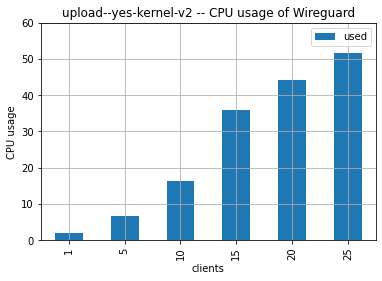

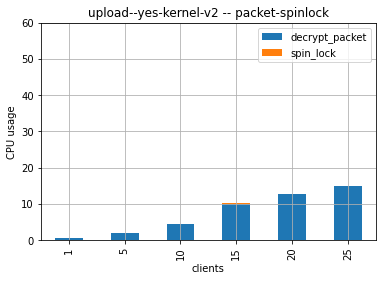

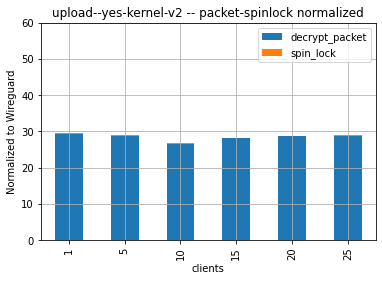

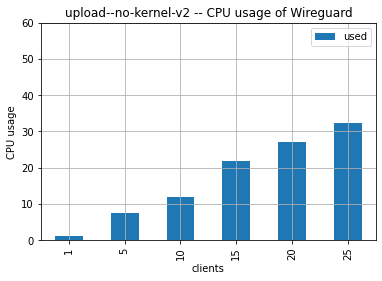

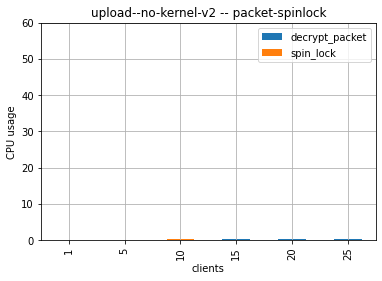

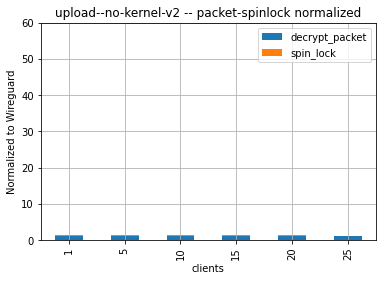

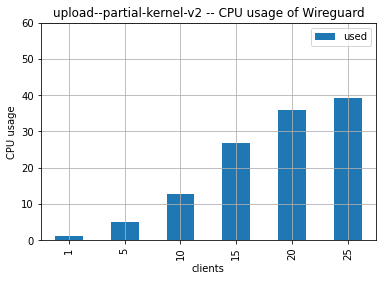

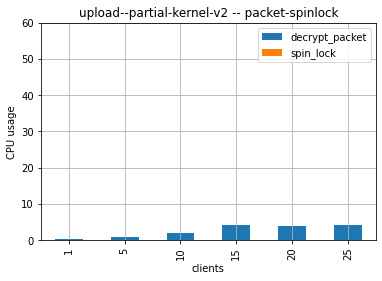

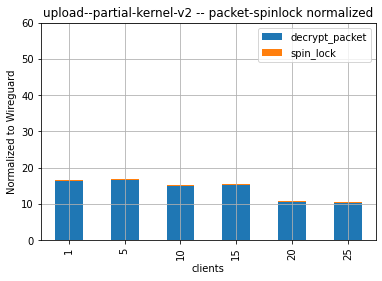

In [15]:
maindir = "../cryptonce-trace-v2"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]
for res_dir in res_dirs:
    df = pd.read_csv(f"{res_dir['path']}/summary/decrypt_time.csv").groupby('clients').mean().reset_index()

    df = pd.read_csv(f"{res_dir['path']}/summary/decrypt_time.csv").groupby('clients').mean().reset_index()
    df = df.reset_index(drop=True)

    cpu, pcpu = import_cpu(res_dir['path'])
    cpu = cpu.reset_index(drop=True)

    df_2 = pd.concat([cpu, df], axis=1)
    df_2.decrypt_packet = df_2.decrypt_packet * df_2.used / 100
    df_2.spin_lock = df_2.spin_lock * df_2.used / 100
    
    df_2.plot.bar(x='clients', y='used', grid=True, ylabel="CPU usage",
                 ylim=[0, 60], 
                 title=f"{res_dir['test']} -- CPU usage of Wireguard")
    plt.show()
    df_2.plot.bar(x='clients', y=['decrypt_packet', 'spin_lock'], 
                grid=True, ylabel="CPU usage", 
                ylim=[0, 60], stacked=True,
                 title=f"{res_dir['test']} -- packet-spinlock")
    plt.show()
    df.plot.bar(x='clients', y=['decrypt_packet', 'spin_lock'], 
                grid=True, ylabel="Normalized to Wireguard", 
                ylim=[0, 60], stacked=True,
                title=f"{res_dir['test']} -- packet-spinlock normalized")
    plt.show()
#     df.plot.bar(x='clients', y=['decrypt_worker'], 
#                 grid=True, ylabel="CPU usage", 
#                 ylim=[0, 40], 
#                 title=f"{res_dir['test']} -- worker")
#     plt.show()